In [18]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import bezier
import csv
from scipy.interpolate import splprep, splev
from scipy.signal import butter, filtfilt

# Define scaling factor: 200 pixels per foot
SCALE = 200  # pixels per foot
WIDTH, HEIGHT = SCALE * 4, SCALE * 4  # 4 ft x 4 ft in pixels

# Initialize Pygame
pygame.init()

# Create a screen with the scaled dimensions
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Draw a Single-Pixel-Width Curved Line with Bezier Curves")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

# Initialize the screen
screen.fill(WHITE)

# Variables to track drawing
drawing = False
points = []
drawn_pixel_times = []  # Store (time, (x, y)) tuples

# Main loop for drawing
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            drawing = True
            points = [event.pos]
            drawn_pixel_times.append((pygame.time.get_ticks(), event.pos))
        elif event.type == pygame.MOUSEMOTION and drawing:
            points.append(event.pos)
            if len(points) > 1:
                pygame.draw.line(screen, BLACK, points[-2], points[-1], 1)
                drawn_pixel_times.append((pygame.time.get_ticks(), points[-1]))
        elif event.type == pygame.MOUSEBUTTONUP:
            drawing = False
            points.append(event.pos)
            if len(points) > 1:
                pygame.draw.line(screen, BLACK, points[-2], points[-1], 1)
                drawn_pixel_times.append((pygame.time.get_ticks(), points[-1]))

    pygame.display.flip()

# Save the screen content to a surface
screen_surface = screen.copy()

# Convert screen content to numpy bitmap array
bitmap_array = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
for y in range(HEIGHT):
    for x in range(WIDTH):
        color = screen_surface.get_at((x, y))
        if color == BLACK:
            bitmap_array[y, x] = 1

pygame.quit()



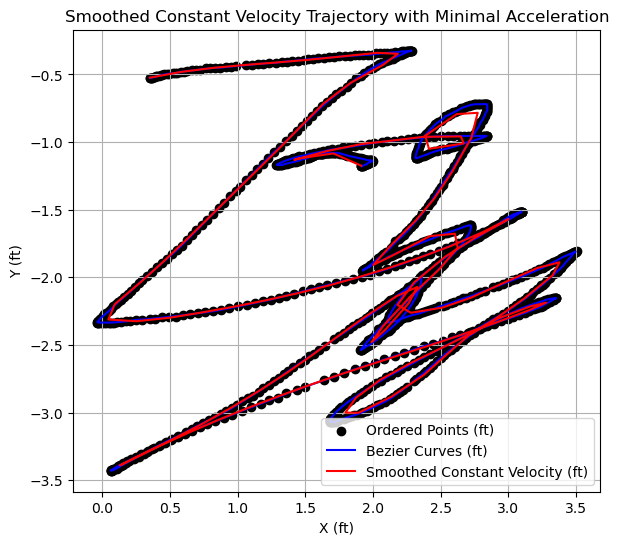

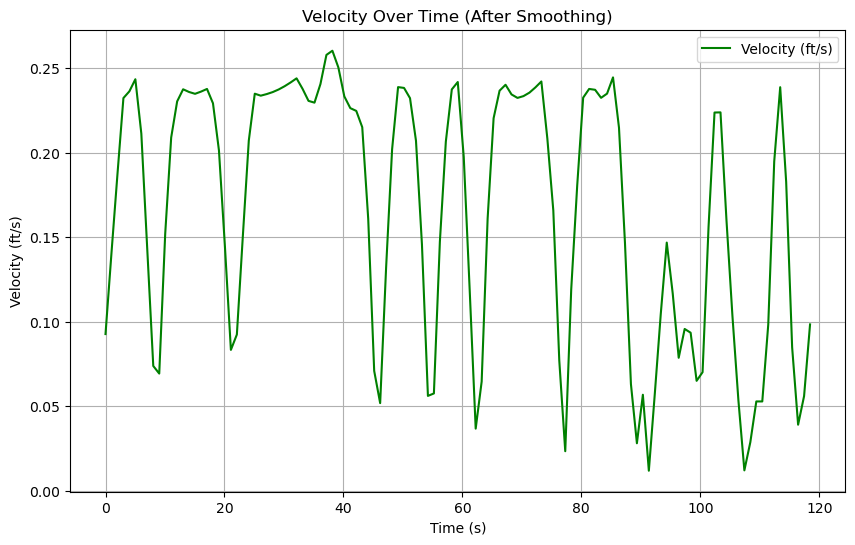

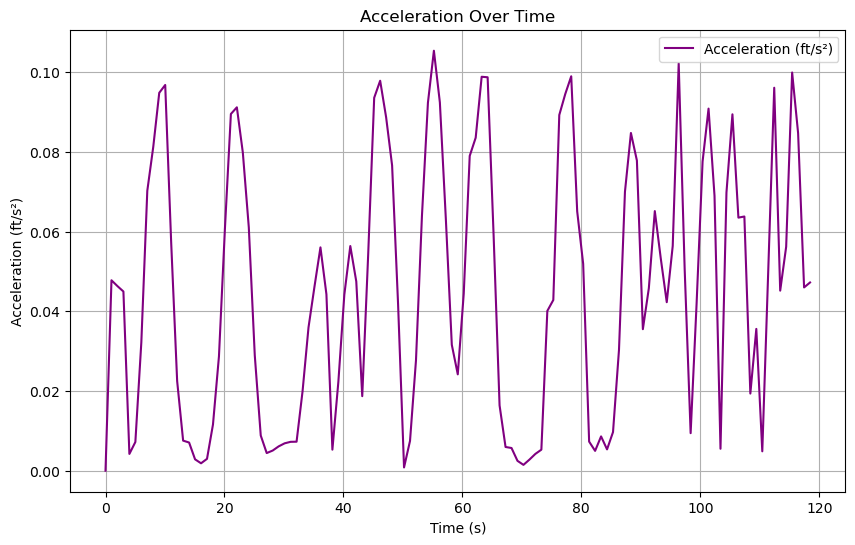

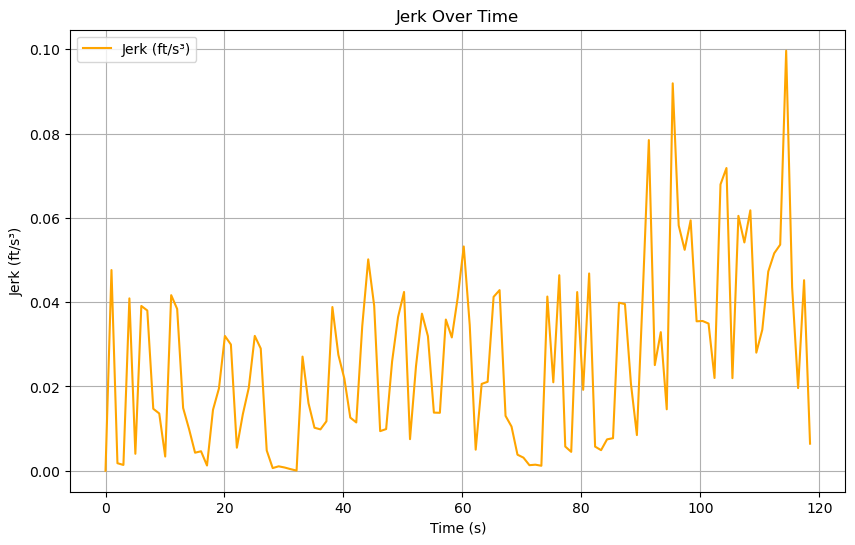

In [19]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore

# Function to apply Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq  # Normalize the frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Extract coordinates of black pixels and sort by drawn time
black_pixel_coords = np.column_stack(np.where(bitmap_array == 1))
sorted_drawn_pixel_times = sorted(drawn_pixel_times, key=lambda x: x[0])
sorted_black_pixel_coords = np.array([coord for _, coord in sorted_drawn_pixel_times]).T

# Sample every 5th point for Bezier smoothing
step = 1
black_pixel_coords_short = sorted_black_pixel_coords[:, ::step]

# Smooth path using Bezier curves
final_sampled_points = []
while black_pixel_coords_short.shape[1] > 1:
    num_points = min(10, black_pixel_coords_short.shape[1])
    nodes = np.asfortranarray(black_pixel_coords_short[:, :num_points])
    bezier_curve = bezier.Curve(nodes, degree=num_points - 1)
    t_values = np.linspace(0, 1, 10)
    sampled_points = bezier_curve.evaluate_multi(t_values)
    final_sampled_points.append(sampled_points)
    black_pixel_coords_short = black_pixel_coords_short[:, num_points - 1:]

if final_sampled_points:
    final_sampled_points = np.hstack(final_sampled_points)
else:
    final_sampled_points = np.empty((2, 0))

# Convert sampled points to feet for plotting
final_sampled_points_ft = final_sampled_points / SCALE

class SampledPointsExporter:
    def __init__(self, points, times, window_size=5, outlier_threshold=1.):
        self.times = times
        self.points = points
        self.window_size = window_size  # Set the window size for the moving average
        self.outlier_threshold = outlier_threshold  # Threshold for z-score to detect outliers
        self.duration = self.times[-1]
        self.apply_translation()
        self.velocity = self.calculate_velocity()  # Calculate velocity immediately upon initialization
        self.velocity = self.apply_moving_average(self.velocity)  # Apply moving average to velocity

    def apply_translation(self):
        """Apply translation to map the first point to the origin."""
        translation_vector = self.points[:, 0]  # First point in the trajectory
        self.points = self.points - translation_vector[:, np.newaxis]  # Shift all points

    def export_to_csv(self, filename):
        """Export the translated points, times, velocities, and absolute velocities to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Time (s)', 'X (ft)', 'Y (ft)', 'Velocity (ft/s)'])
            for i in range(self.points.shape[1]):
                # Calculate the magnitude of the velocity vector at each point
                abs_velocity = np.linalg.norm(self.velocity[:, i])  # Absolute value (magnitude) of velocity vector
                writer.writerow([self.times[i], self.points[0, i], self.points[1, i], abs_velocity])

    def calculate_velocity(self):
        """Calculate the velocity at each point, smoothing outliers in the data."""
        n = self.points.shape[1]
        velocity = np.zeros((2, n))

        # Calculate raw velocity
        for i in range(1, n):
            dt = (self.times[i] - self.times[i - 1])  # Time difference in seconds
            if dt > 0:  # Avoid division by zero
                velocity[:, i] = (self.points[:, i] - self.points[:, i - 1]) / dt

        # Flatten and apply z-score to identify outliers in both dimensions
        velocity_flat = velocity.T.reshape(-1)
        velocity_zscores = np.abs(zscore(velocity_flat))

        # Flag points with a z-score higher than the threshold
        outlier_indices = np.where(velocity_zscores > self.outlier_threshold)[0]

        # Replace outliers with interpolated values from nearest non-outlier neighbors
        for idx in outlier_indices:
            dim = idx // n
            point = idx % n

            # Find previous and next non-outlier points in the same dimension
            prev_non_outlier = next_non_outlier = None

            # Look backward for previous non-outlier
            for j in range(point - 1, -1, -1):
                if (j + dim * n) not in outlier_indices:
                    prev_non_outlier = velocity[dim, j]
                    break

            # Look forward for next non-outlier
            for j in range(point + 1, n):
                if (j + dim * n) not in outlier_indices:
                    next_non_outlier = velocity[dim, j]
                    break

            # Interpolate if both neighbors are found
            if prev_non_outlier is not None and next_non_outlier is not None:
                velocity[dim, point] = (prev_non_outlier + next_non_outlier) / 2
            # If only one neighbor is found, use it as a replacement
            elif prev_non_outlier is not None:
                velocity[dim, point] = prev_non_outlier
            elif next_non_outlier is not None:
                velocity[dim, point] = next_non_outlier

        return velocity  # Returns smoothed velocity in feet per second


    def apply_moving_average(self, velocity):
        """Applies a moving average filter to smooth the velocity."""
        smoothed_velocity = np.zeros_like(velocity)
        
        # Apply moving average to each dimension (X and Y)
        for dim in range(2):  # Loop through X and Y dimensions
            smoothed_velocity[dim] = np.convolve(velocity[dim], np.ones(self.window_size) / self.window_size, mode='same')

        return smoothed_velocity

# Set the desired velocity in pixels per second
desired_velocity_ft_per_s = 0.25
pixels_per_second = desired_velocity_ft_per_s * SCALE

# Smooth constant velocity trajectory function with time tracking
def smooth_constant_velocity_trajectory(points, velocity, v_max = desired_velocity_ft_per_s, accel = 0.1, smooth_factor=.1, density_scale=1):
    # Calculate cumulative distances between each point
    cumulative_distances = np.cumsum(np.linalg.norm(np.diff(points, axis=1), axis=0))
    total_distance = cumulative_distances[-1] if cumulative_distances.size > 0 else 0

    # Define target number of points based on constant velocity and increase the density
    n_points = int(total_distance / velocity) * density_scale + 1  # Increased number of points
    distances = np.linspace(0, total_distance, n_points)

    # Resample points at constant distances for uniform velocity
    traj_points = np.zeros((2, n_points))
    times = np.zeros(n_points)
    current_index = 0
    
    for i, target_distance in enumerate(distances):
        while current_index < len(cumulative_distances) and cumulative_distances[current_index] < target_distance:
            current_index += 1

        if current_index == 0:
            traj_points[:, i] = points[:, 0]
            times[i] = 0  # Start at time 0
        elif current_index < len(cumulative_distances):
            p1 = points[:, current_index - 1]
            p2 = points[:, current_index]
            d1 = cumulative_distances[current_index - 1]
            d2 = cumulative_distances[current_index]
            ratio = (target_distance - d1) / (d2 - d1)
            traj_points[:, i] = (1 - ratio) * p1 + ratio * p2
            times[i] = distances[i] / velocity
        else:
            traj_points[:, i] = points[:, -1]
            times[i] = distances[i] / velocity

    # Remove repeated points and keep time in sync
    unique_points = []
    unique_times = []
    tolerance = 1e-6  # Define a small tolerance for floating-point comparison

    i = 1

    for i in range(traj_points.shape[1]):
        if len(unique_points) == 0 or np.linalg.norm(traj_points[:, i] - unique_points[-1]) > tolerance:
            unique_points.append(traj_points[:, i])
            unique_times.append(times[i])
        else:
            print(i)
            i += 1

    # Convert unique_points back to a NumPy array and unique_times to a proper array
    traj_points = np.array(unique_points).T
    times = np.array(unique_times)

    # Apply B-spline smoothing to minimize acceleration
    tck, _ = splprep(traj_points, s=smooth_factor)
    smoothed_traj = np.array(splev(np.linspace(0, 1, traj_points.shape[1]), tck))

    times = times[:smoothed_traj.shape[1]]

    return smoothed_traj, times  # Return smoothed trajectory and corresponding times

# Flip final sampled points about the x-axis by negating the y-coordinates
final_sampled_points_ft[1, :] = -final_sampled_points_ft[1, :]

# Flip sorted_black_pixel_coords for plotting
sorted_black_pixel_coords[1, :] = -sorted_black_pixel_coords[1, :]

# Generate smoothed constant velocity trajectory
smoothed_constant_velocity = smooth_constant_velocity_trajectory(
    final_sampled_points_ft, 
    desired_velocity_ft_per_s
)

smoothed_constant_velocity_points = smoothed_constant_velocity[0]
times = smoothed_constant_velocity[1]
smoothed_constant_velocity_points_ft = smoothed_constant_velocity_points

# Export smoothed points to CSV
exporter = SampledPointsExporter(smoothed_constant_velocity_points_ft, times)
exporter.export_to_csv('smoothed_sampled_points.csv')

# Calculate and plot velocity
velocity = exporter.velocity
velocity_ft_per_s = np.linalg.norm(velocity, axis=0)

# Plot trajectory and velocity
plt.figure(figsize=(10, 6))
plt.scatter(sorted_black_pixel_coords[0] / SCALE, sorted_black_pixel_coords[1] / SCALE, color='black', label='Ordered Points (ft)')
plt.plot(final_sampled_points_ft[0], final_sampled_points_ft[1], color='blue', label='Bezier Curves (ft)')
plt.plot(smoothed_constant_velocity_points_ft[0], smoothed_constant_velocity_points_ft[1], color='red', label='Smoothed Constant Velocity (ft)')
plt.title('Smoothed Constant Velocity Trajectory with Minimal Acceleration')
plt.xlabel('X (ft)')
plt.ylabel('Y (ft)')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid()
plt.show()

# Plot velocity over time
plt.figure(figsize=(10, 6))
plt.plot(times, velocity_ft_per_s, color='green', label='Velocity (ft/s)')
plt.title('Velocity Over Time (After Smoothing)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (ft/s)')
plt.legend()
plt.grid()
plt.show()

# Calculate acceleration (derivative of velocity)
acceleration = np.zeros(velocity.shape)
for i in range(1, velocity.shape[1]):
    dt = times[i] - times[i - 1]
    if dt > 0:
        acceleration[:, i] = (velocity[:, i] - velocity[:, i - 1]) / dt

# Calculate the norm of the acceleration vector for easier plotting
acceleration_ft_per_s2 = np.linalg.norm(acceleration, axis=0)

# Plot acceleration over time
plt.figure(figsize=(10, 6))
plt.plot(times, acceleration_ft_per_s2, color='purple', label='Acceleration (ft/s²)')
plt.title('Acceleration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (ft/s²)')
plt.legend()
plt.grid()
plt.show()

# Calculate jerk (derivative of acceleration)
jerk = np.zeros(acceleration.shape)
for i in range(1, acceleration.shape[1]):
    dt = times[i] - times[i - 1]
    if dt > 0:
        jerk[:, i] = (acceleration[:, i] - acceleration[:, i - 1]) / dt

# Calculate the norm of the jerk vector for easier plotting
jerk_ft_per_s3 = np.linalg.norm(jerk, axis=0)

# Plot jerk over time
plt.figure(figsize=(10, 6))
plt.plot(times, jerk_ft_per_s3, color='orange', label='Jerk (ft/s³)')
plt.title('Jerk Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Jerk (ft/s³)')
plt.legend()
plt.grid()
plt.show()


Loaded DataFrame:
   Time (s)    X (ft)    Y (ft)  Velocity (ft/s)
0  0.000000  0.000000  0.000000         0.092718
1  1.003768  0.228911  0.042305         0.140698
2  2.007535  0.466926  0.072259         0.187200
3  3.011303  0.706517  0.094232         0.232349
4  4.015070  0.940158  0.112597         0.236334
Loaded File
Begin Flight


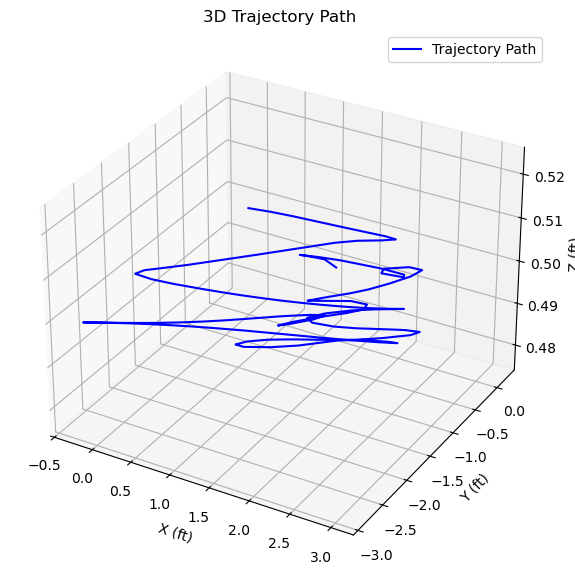

460.9970237300945


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load data from the Excel file and process it
def load_and_process_csv(file_path):
    # Load the data from the CSV file
    df = pd.read_csv(file_path)

    # Display the loaded DataFrame to check
    print('Loaded DataFrame:')
    print(df.head())

    # Convert columns to numpy arrays
    times = df['Time (s)'].to_numpy()
    x_coords = df['X (ft)'].to_numpy()
    y_coords = df['Y (ft)'].to_numpy()
    velocity = df['Velocity (ft/s)'].to_numpy()

    # Return the processed arrays
    return times, x_coords, y_coords, velocity

def move_along_curve(curve, z):
    file_path = curve  # Update with the actual file path
    times, x_coords, y_coords, velocity = load_and_process_csv(file_path)

    print('Loaded File')

    # Convert times, x_coords, y_coords, velocity to numpy arrays
    times = np.array(times)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    velocity = np.array(velocity)

    # Z-coordinate is constant, as passed into the function
    z_coords = z * np.ones_like(x_coords)

    # Stack the coordinates (X, Y, Z)
    coords = np.vstack((x_coords, y_coords, z_coords)).T

    total_time = 0

    traj = np.array([[0,0,0,0]])

    print('Begin Flight')

    # Loop through each segment of the path
    for i in range(len(coords) - 1):
        p_inW_1 = coords[i]
        p_inW_2 = coords[i + 1]

        # Calculate the distance between the points
        d = np.linalg.norm(p_inW_1 - p_inW_2)

        # Calculate the time it should take to move based on the velocity at this segment
        dt = d / velocity[i]

        # Get the time at which to start moving this segment
        segment_time = 0

        fr = 1./60.

        # Loop to move the drone in the current segment
        while True:
            # Calculate the fraction of the path to be covered at this time point
            s = min(segment_time / dt, 1.0)  # Ensure s doesn't exceed 1.0
                
            # Interpolate the position along the path
            p_inW_des = (1 - s) * p_inW_1 + s * p_inW_2

            # saves desired position
            traj_new = np.hstack((p_inW_des[0], p_inW_des[1], p_inW_des[2], total_time))
            traj = np.vstack((traj, traj_new))

            # If the segment is complete, break out of the loop for this segment
            if s >= 1.0:
                total_time += dt + fr
                segment_time += fr
                break
            else:
                total_time += fr
                segment_time += fr
    traj = traj[1:,:]

    return traj

# Load data and compute the trajectory
trajectory = move_along_curve('smoothed_sampled_points.csv', 0.50)

# Extract coordinates for plotting
x_coords = trajectory[:, 0]
y_coords = trajectory[:, 1]
z_coords = trajectory[:, 2]

# Plot the trajectory in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_coords, y_coords, z_coords, label='Trajectory Path', color='blue')
ax.set_xlabel('X (ft)')
ax.set_ylabel('Y (ft)')
ax.set_zlabel('Z (ft)')
ax.set_title('3D Trajectory Path')
ax.legend()

plt.show()

total_time = trajectory[:, 3][-1]

print(total_time)


